In [1]:
import networkx as nx
import math

def bpr_time(ff_time, flow, capacity, alpha=0.15, beta=4):
    return ff_time * (1 + alpha * (flow/capacity)**beta)

def user_equilibrium_assignment(G, OD, max_iter=50, tol=1e-3):
    # 1) Initialize flows
    for u, v, k, data in G.edges(data=True, keys=True):
        data['flow'] = 0.0

    # 2) Main iteration
    for it in range(1, max_iter+1):
        print(f"Iteration {it}")
        # Step 2.1: All-or-nothing w.r.t. current link times
        # Temporary flows start at zero
        temp_flow = {}
        for (u, v, k) in G.edges(keys=True):
            temp_flow[(u, v, k)] = 0.0

        # Update link travel times using BPR
        for u, v, k, data in G.edges(data=True, keys=True):
            ff_time = data['ff_time']
            flow = data['flow']
            cap = data['capacity']
            data['time'] = bpr_time(ff_time, flow, cap)

        print("Initialized")

        # Build a shortest-path structure
        # For large networks, consider Johnson's or repeated Dijkstra
        # Here, do a simple approach for demonstration
        # precompute shortest paths or do them on-the-fly for each OD
        for (o, d), demand in OD.items():
            if demand <= 0:
                continue
            # Dijkstra or BFS on travel time
            try:
                path = nx.shortest_path(G, source=o, target=d, weight='time')
            except:
                print(f"No path between nodes: {o, d}")
            # Assign flow
            for i in range(len(path)-1):
                edge_key = (path[i], path[i+1], 0)
                # find correct key if multi-edges
                if not G.has_edge(path[i], path[i+1], 0):
                    # handle multi-edge scenario
                    possible_keys = list(G[path[i]][path[i+1]].keys())
                    # for simplicity, assume first key
                    edge_key = (path[i], path[i+1], possible_keys[0])
                temp_flow[edge_key] += demand

        print("Accumulated flows")

        # Step 2.2: MSA flow update
        alpha_k = 1.0 / it
        flow_change = 0.0
        for (u, v, k, data) in G.edges(data=True, keys=True):
            oldF = data['flow']
            newF = oldF + alpha_k * (temp_flow[(u, v, k)] - oldF)
            flow_change += abs(newF - oldF)
            data['flow'] = newF

        # Step 2.3: Check Convergence
        if flow_change < tol:
            print(f"Converged at iteration {it} with flow_change={flow_change}")
            break

    return G


In [6]:
import os
import osmnx as ox
import networkx as nx
import re

def preprocess_maxspeed(G):
    for u, v, k, data in G.edges(data=True, keys=True):
        maxspeed = data.get('maxspeed', None)
        if maxspeed:
            if isinstance(maxspeed, list):
                # If maxspeed is a list, extract numeric values and take the maximum
                speeds = [convert_to_kmh(speed) for speed in maxspeed if re.findall(r'\d+', speed)]
                if speeds:
                    data['maxspeed'] = max(speeds)
                else:
                    data['maxspeed'] = None
            else:
                # If maxspeed is a single value, extract the numeric value
                data['maxspeed'] = convert_to_kmh(maxspeed)
        else:
            data['maxspeed'] = None

def convert_to_kmh(speed):
    # Extract numeric value
    value = re.findall(r'\d+', speed)
    if not value:
        return None
    value = float(value[0])
    
    # Check if the speed is in mph and convert to km/h
    if 'mph' in speed.lower():
        return value * 1.60934  # Convert mph to km/h
    else:
        return value  # Assume the speed is already in km/h

In [9]:
ox.settings.all_oneway = True

# Example: create a bounding box or place name
place_name = "Hamilton County, TN, USA"

# Available options for network_type in OSMnx include:
#   'drive'         - for drivable public roads
#   'drive_service' - for drivable roads including service roads
#   'walk'          - for pedestrian networks
#   'bike'          - for cycling networks
#   'all'           - for all ways regardless of use
#   'all_private'   - for all roads including private ones

G = ox.graph_from_place(place_name, network_type='drive_service')
roads = list(G.edges(data=True))
print("Total number of roads:", len(roads))
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

os.makedirs('osmx_files/', exist_ok=True)
# Convert any columns that contain lists to strings to avoid errors when writing shapefile
for col in edges.columns:
	if edges[col].apply(lambda x: isinstance(x, list)).any():
		edges[col] = edges[col].astype(str)
edges.to_file("osmnx_files/county_edges.shp")

preprocess_maxspeed(G)

ox.save_graphml(G, "osmnx_files/hamilton_county_drive_service.graphml")
ox.io.save_graph_xml(G, filepath="osmnx_files/hamilton_county.osm.xml")

Total number of roads: 56524


In [3]:
import math

for u, v, key, data in G.edges(keys=True, data=True):
    # data['length'] is in meters
    # data.get('maxspeed') might be missing, so let's approximate
    highway_type = data.get('highway', None)
    
    if highway_type in ['motorway', 'motorway_link']:
        data['capacity'] = 2000  # vehicles/hour/lane (example)
        data['ff_speed'] = 100  # km/h
    elif highway_type in ['primary', 'secondary']:
        data['capacity'] = 1500
        data['ff_speed'] = 80
    else:
        data['capacity'] = 800
        data['ff_speed'] = 40

    # Compute free-flow travel time in hours:
    length_km = data['length'] / 1000.0
    data['ff_time'] = length_km / data['ff_speed']  # hours


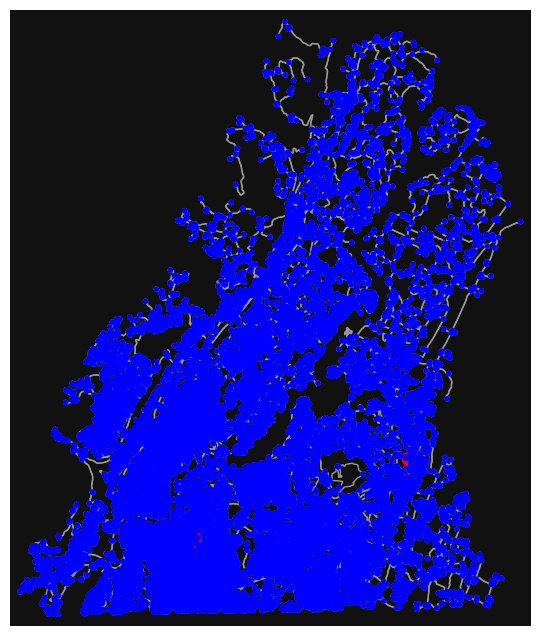

In [7]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Define the nodes
node1 = 1863750036
node2 = 459568214

# Function to compute shortest path and check if path exists
def check_path(G, o, d, weight):
    try:
        path = nx.shortest_path(G, source=o, target=d, weight=weight)
        return True
    except nx.NetworkXNoPath:
        print(f"No path between nodes: {o} and {d}")
        return False
    except nx.NodeNotFound:
        print(f"Node not found in graph: {o} or {d}")
        return False

# Check if path exists
path_exists = check_path(G, node1, node2, 'time')

# Plot the graph
fig, ax = ox.plot_graph(G, show=False, close=False)

# Highlight the specific nodes
# Compute positions of nodes from their 'x' and 'y' attributes in G
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=node_sizes, ax=ax)
node_colors = ['r' if node in [node1, node2] else 'b' for node in G.nodes()]
node_sizes = [100 if node in [node1, node2] else 10 for node in G.nodes()]

plt.show()

In [6]:
check_path(G, 1863750036, 12352486144, 'time')

No path between nodes: 1863750036 and 12352486144


False

In [8]:
import pandas as pd

od_path = './move_od/lodes_0.csv'
input_od = pd.read_csv(od_path)
node_ids = list(G.nodes())

In [9]:
from joblib import Parallel, delayed
import osmnx as ox

# Function to find nearest nodes
def find_nearest_nodes(o_lon, o_lat, d_lon, d_lat):
    o_node = ox.distance.nearest_nodes(G, o_lon, o_lat)
    d_node = ox.distance.nearest_nodes(G, d_lon, d_lat)
    return o_node, d_node

# Extract relevant rows
drive_trips = input_od[input_od["mode_type"] == "drive"]

# Extract lat-lon
o_lat = drive_trips["origin_loc_lat"].values
o_lon = drive_trips["origin_loc_lon"].values
d_lat = drive_trips["dest_loc_lat"].values
d_lon = drive_trips["dest_loc_lon"].values

# Parallel processing
o_nodes = ox.distance.nearest_nodes(G, o_lon, o_lat)
d_nodes = ox.distance.nearest_nodes(G, d_lon, d_lat)

print("Got nodes")

# Initialize OD dictionary
OD = {}

# Accumulate in OD dictionary
for o_node, d_node in zip(o_nodes, d_nodes):
    if (o_node, d_node) not in OD:
        OD[(o_node, d_node)] = 0
    OD[(o_node, d_node)] += 1  # Assuming each row is a single trip

Got nodes


In [ ]:
G = user_equilibrium_assignment(G, OD, max_iter=50, tol=1e-3)

Iteration 1
Initialized
No path between nodes: (1863750036, 12352486144)
No path between nodes: (6292514325, 12352486144)
No path between nodes: (202653105, 12352486144)
No path between nodes: (7043061401, 934182168)
No path between nodes: (7043061401, 1518182694)
No path between nodes: (7043061401, 3742394153)
No path between nodes: (7043061401, 6028576700)
No path between nodes: (7043061401, 1296543148)
No path between nodes: (7043061401, 202703010)
No path between nodes: (5508701884, 2343756785)
No path between nodes: (10116561419, 2343756785)
No path between nodes: (945174790, 2343756785)
No path between nodes: (202592729, 2343756785)
No path between nodes: (202668433, 10897961486)
No path between nodes: (6292514325, 10897961486)
No path between nodes: (6405279907, 10897961486)
No path between nodes: (202592729, 10897961486)
No path between nodes: (202592729, 12352486144)
No path between nodes: (4545061790, 12352486144)
No path between nodes: (202567456, 12352486144)
No path betwee